In [ ]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = y_train.reshape(len(y_train), 1)
y_train1 = onehot_encoder.fit_transform(integer_encoded)
print(y_train1[0])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [ ]:
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = y_test.reshape(len(y_test), 1)
y_test1 = onehot_encoder.fit_transform(integer_encoded)
print(y_test1[0])

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [ ]:
train_x = x_train.reshape(x_train.shape[0], -1)
test_x = x_test.reshape(x_test.shape[0], -1)

In [ ]:
train_x = train_x/255
test_x = test_x/255

In [ ]:
print(train_x.shape)

(60000, 784)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import time

In [ ]:
class DeepNeuralNetwork():
    def __init__(self, sizes, activation='sigmoid'):
        self.sizes = sizes
        self.train_loss_list = []
        self.test_loss_list = []
        self.train_accuracy_list = []
        self.test_accuracy_list = []
        self.grad_list = []

        # Choose activation function
        if activation == 'relu':
            self.activation = self.relu
        elif activation == 'sigmoid':
            self.activation = self.sigmoid
        else:
            raise ValueError("relu' or 'sigmoid' is only supported.")
        
        # Save all weights
        self.params = self.initialize()
        # Save all intermediate values, i.e. activations
        self.cache = {}
        
    def relu(self, x, derivative=False):
        '''
            Derivative of ReLU is a bit more complicated since it is not differentiable at x = 0
        
            Forward path:
            relu(x) = max(0, x)
            In other word,
            relu(x) = 0, if x < 0
                    = x, if x >= 0

            Backward path:
            ∇relu(x) = 0, if x < 0
                     = 1, if x >=0
        '''
        if derivative:
            x = np.where(x < 0, 0, x)
            x = np.where(x >= 0, 1, x)
            return x
        return np.maximum(0, x)

    def sigmoid(self, x, derivative=False):
        '''
            Forward path:
            σ(x) = 1 / 1+exp(-z)
            
            Backward path:
            ∇σ(x) = exp(-z) / (1+exp(-z))^2
        '''
        if derivative:
            return (np.exp(-x))/((np.exp(-x)+1)**2)
        return 1/(1 + np.exp(-x))

    def softmax(self, x):
        '''
            softmax(x) = exp(x) / ∑exp(x)
        '''
        # Numerically stable with large exponentials
        exps = np.exp(x - x.max())
        return exps / np.sum(exps, axis=0)

    def initialize(self):
        # number of nodes in each layer
        input_layer=self.sizes[0]
        params = {}
        for i in range(1,len(self.sizes)):
          hidden_layer_prev = self.sizes[i-1]
          hidden_layer=self.sizes[i]
          params["W{}".format(i)] = np.random.randn(hidden_layer, hidden_layer_prev) * np.sqrt(1./hidden_layer_prev)
          params["b{}".format(i)] = np.zeros((hidden_layer, 1)) * np.sqrt(1./hidden_layer_prev)

        """output_layer=self.sizes[-1]
        params["W{}".format(len(self.sizes)-1)] = np.random.randn(output_layer, hidden_layer) * np.sqrt(1./hidden_layer)
        params["b{}".format(len(self.sizes)-1)] = np.zeros((output_layer, 1)) * np.sqrt(1./hidden_layer)"""
        
        """params = {
            "W1": np.random.randn(hidden_layer, input_layer) * np.sqrt(1./input_layer),
            "b1": np.zeros((hidden_layer, 1)) * np.sqrt(1./input_layer),
            "W2": np.random.randn(output_layer, hidden_layer) * np.sqrt(1./hidden_layer),
            "b2": np.zeros((output_layer, 1)) * np.sqrt(1./hidden_layer)
        }"""
        return params
    
    def initialize_momemtum_optimizer(self):
        momemtum_opt = {
            "W1": np.zeros(self.params["W1"].shape),
            "b1": np.zeros(self.params["b1"].shape),
            "W2": np.zeros(self.params["W2"].shape),
            "b2": np.zeros(self.params["b2"].shape),
        }
        return momemtum_opt

    def feed_forward(self, x):
        '''
            y = σ(wX + b)
        '''
        self.cache["X"] = x
        self.cache["A0"] = x.T
        for i in range(1,len(self.sizes)):
          self.cache["Z{}".format(i)] = np.matmul(self.params["W{}".format(i)], self.cache["A{}".format(i-1)]) + self.params["b{}".format(i)]
          self.cache["A{}".format(i)] = self.activation(self.cache["Z{}".format(i)])

        """self.cache["Z1"] = np.matmul(self.params["W1"], self.cache["X"].T) + self.params["b1"]
        
        self.cache["A1"] = self.activation(self.cache["Z1"])"""
        
        
        """self.cache["Z2"] = np.matmul(self.params["W2"], self.cache["A1"]) + self.params["b2"]
        self.cache["A2"] = self.softmax(self.cache["Z2"])"""
        return self.cache["A{}".format(len(self.sizes)-1)]
    
    def back_propagate(self, y, output):
        '''
            This is the backpropagation algorithm, for calculating the updates
            of the neural network's parameters.

            Note: There is a stability issue that causes warnings. This is 
                  caused  by the dot and multiply operations on the huge arrays.
                  
                  RuntimeWarning: invalid value encountered in true_divide
                  RuntimeWarning: overflow encountered in exp
                  RuntimeWarning: overflow encountered in square
        '''
        current_batch_size = y.shape[0]
        
        dZ2 = output - y.T
        dW2 = (1./current_batch_size) * np.matmul(dZ2, self.cache["A{}".format(len(self.sizes)-2)].T)
        db2 = (1./current_batch_size) * np.sum(dZ2, axis=1, keepdims=True)

        self.grads = {}
        self.grads["W{}".format(len(self.sizes)-1)] = dW2
        self.grads["b{}".format(len(self.sizes)-1)] = db2
        
        dZ_prev = dZ2
        
        for i in range(len(self.sizes)-2,0,-1):
          dA = np.matmul(self.params["W{}".format(i+1)].T, dZ_prev)
          dZ = dA * self.activation(self.cache["Z{}".format(i)], derivative=True)
          #if(i==1):
          dW = (1./current_batch_size) * np.matmul(dZ, self.cache["A{}".format(i-1)].T)
          """else:
            print("A size is",self.cache["A{}".format(i)].shape)
            print("A size is",self.cache["A{}".format(i-1)].shape)
            #print("W size is",self.grads["W{}".format(i-1)].shape)
            print("dZ size is",dZ.shape)
            dW = (1./current_batch_size) * np.matmul(dZ, self.cache["A{}".format(i-1)])"""
          db = (1./current_batch_size) * np.sum(dZ, axis=1, keepdims=True)
          dZ_prev = dZ
          self.grads["W{}".format(i)] = dW
          self.grads["b{}".format(i)] = db

        """dA1 = np.matmul(self.params["W2"].T, dZ2)
        dZ1 = dA1 * self.activation(self.cache["Z1"], derivative=True)
        dW1 = (1./current_batch_size) * np.matmul(dZ1, self.cache["X"])
        db1 = (1./current_batch_size) * np.sum(dZ1, axis=1, keepdims=True)

        self.grads = {"W1": dW1, "b1": db1, "W2": dW2, "b2": db2}"""
        return self.grads
    
    def cross_entropy_loss(self, y, output):
        '''
            L(y, ŷ) = −∑ylog(ŷ).
        '''
        output = np.where(output<0.000001,1,output)
        #print(output[0])
        l_sum = np.sum(np.multiply(y.T, np.log(output)))
        m = y.shape[0]
        l = -(1./m) * l_sum
        return l
    def my_loss(self,y,output):
        m = y.shape[0]
        A = output

        return np.squeeze(-(1./m)*np.sum(np.multiply(y.T, np.log(A))+np.multiply(np.log(1-A), 1-y.T)))
                
    def optimize(self, l_rate=0.1, beta=.9):
        '''
            Stochatic Gradient Descent (SGD):
            θ^(t+1) <- θ^t - η∇L(y, ŷ)
            
            Momentum:
            v^(t+1) <- βv^t + (1-β)∇L(y, ŷ)^t
            θ^(t+1) <- θ^t - ηv^(t+1)
        '''
        if self.optimizer == "sgd":
            for key in self.params:
                self.params[key] = self.params[key] - l_rate * self.grads[key]
        elif self.optimizer == "momentum":
            for key in self.params:
                self.momemtum_opt[key] = (beta * self.momemtum_opt[key] + (1. - beta) * self.grads[key])
                self.params[key] = self.params[key] - l_rate * self.momemtum_opt[key]
        else:
            raise ValueError("Optimizer is currently not support, please use 'sgd' or 'momentum' instead.")

    def accuracy(self, y, output):
        return np.mean(np.argmax(y, axis=-1) == np.argmax(output.T, axis=-1))

    def train(self, x_train, y_train, x_test, y_test, epochs=10, 
              batch_size=64, optimizer='momentum', l_rate=0.1, beta=.9):
        # Hyperparameters
        self.epochs = epochs
        self.batch_size = batch_size
        num_batches = -(-x_train.shape[0] // self.batch_size)
        
        # Initialize optimizer
        self.optimizer = optimizer
        if self.optimizer == 'momentum':
            self.momemtum_opt = self.initialize_momemtum_optimizer()
        
        start_time = time.time()
        template = "Epoch {}: {:.5f}s, train acc={:.5f}, train loss={:.5f}, test acc={:.5f}, test loss={:.5f}"
        
        # Train
        for i in range(self.epochs):
            # Shuffle
            permutation = np.random.permutation(x_train.shape[0])

            x_train_shuffled = x_train[permutation]
            y_train_shuffled = y_train[permutation]
            if(optimizer == 'sgd'):
              x_train_shuffled = x_train_shuffled[0:self.batch_size]
              y_train_shuffled = y_train_shuffled[0:self.batch_size]
              num_batches = 1
            for j in range(num_batches):
                # Batch
                begin = j * self.batch_size
                end = min(begin + self.batch_size, x_train.shape[0]-1)
                x = x_train_shuffled[begin:end]
                y = y_train_shuffled[begin:end]
                
                # Forward
                output = self.feed_forward(x)
                # Backprop
                grad = self.back_propagate(y, output)
                # Optimize
                self.optimize(l_rate=l_rate, beta=beta)

            # Evaluate performance
            # Training data
            output = self.feed_forward(x_train)
            train_acc = self.accuracy(y_train, output)
            train_loss = self.cross_entropy_loss(y_train, output)
            self.train_loss_list.append(train_loss)
            self.train_accuracy_list.append(train_acc)
            self.grad_list.append(self.grads)
            # Test data
            output = self.feed_forward(x_test)
            test_acc = self.accuracy(y_test, output)
            test_loss = self.cross_entropy_loss(y_test, output)
            self.test_loss_list.append(test_loss)
            self.test_accuracy_list.append(test_acc)
            print(template.format(i+1, time.time()-start_time, train_acc, train_loss, test_acc, test_loss))

In [ ]:
print(train_x.shape)

(60000, 784)


In [ ]:
# ReLU + GD
dnn2 = DeepNeuralNetwork(sizes=[784, 64, 10], activation='sigmoid')
dnn2.train(train_x, y_train1, test_x, y_test1,epochs=200, batch_size=train_x.shape[0], optimizer='sgd', l_rate=0.05)

Epoch 1: 1.53388s, train acc=0.10668, train loss=0.92908, test acc=0.10020, test loss=0.92915
Epoch 2: 3.12266s, train acc=0.10797, train loss=1.10226, test acc=0.10280, test loss=1.10256
Epoch 3: 4.69343s, train acc=0.10917, train loss=1.25527, test acc=0.10270, test loss=1.25579
Epoch 4: 6.26070s, train acc=0.11340, train loss=1.38834, test acc=0.10710, test loss=1.38908
Epoch 5: 7.82532s, train acc=0.11903, train loss=1.50313, test acc=0.11350, test loss=1.50409
Epoch 6: 9.40162s, train acc=0.12538, train loss=1.60177, test acc=0.11750, test loss=1.60295
Epoch 7: 10.95697s, train acc=0.13243, train loss=1.68643, test acc=0.12630, test loss=1.68781
Epoch 8: 12.51881s, train acc=0.14092, train loss=1.75907, test acc=0.13310, test loss=1.76063
Epoch 9: 14.12457s, train acc=0.15132, train loss=1.82144, test acc=0.14280, test loss=1.82315
Epoch 10: 15.68472s, train acc=0.16545, train loss=1.87501, test acc=0.15660, test loss=1.87685
Epoch 11: 17.26160s, train acc=0.18538, train loss=1.92

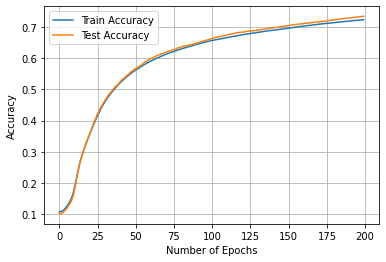

In [ ]:
train_accuracy = dnn2.train_accuracy_list
test_accuracy = dnn2.test_accuracy_list

plt.plot(train_accuracy,label='Train Accuracy')
plt.plot(test_accuracy,label='Test Accuracy')
plt.legend()
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.grid()
plt.savefig("accuracy_gd.jpg")
plt.show()

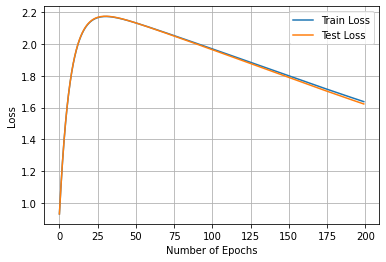

In [ ]:
train_loss = dnn2.train_loss_list
test_loss = dnn2.test_loss_list

plt.plot(train_loss,label='Train Loss')
plt.plot(test_loss,label='Test Loss')
plt.legend()
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.grid()
plt.savefig("loss_gd.jpg")
plt.show()

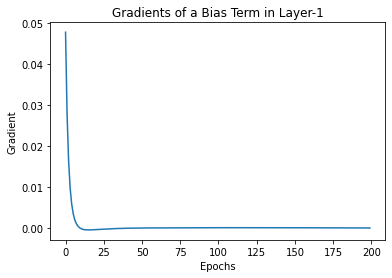

In [ ]:
grads = dnn2.grad_list

b1 = []
for i in range(len(grads)):
  b1.append(grads[i]["b1"][1,0])

plt.plot(b1)
plt.title("Gradients of a Bias Term in Layer-1")
plt.xlabel("Epochs")
plt.ylabel("Gradient")
plt.savefig("grad_gd.jpg")
plt.show()

# SGD

In [ ]:
# Sigmoid + SGD
dnn3 = DeepNeuralNetwork(sizes=[784, 64, 10], activation='sigmoid')
dnn3.train(train_x, y_train1, test_x, y_test1,epochs=2000, batch_size=1, optimizer='sgd', l_rate=0.05)

Epoch 1: 0.62356s, train acc=0.11237, train loss=0.89189, test acc=0.11350, test loss=0.89084
Epoch 2: 1.28363s, train acc=0.11767, train loss=1.09625, test acc=0.12690, test loss=1.09337
Epoch 3: 1.92598s, train acc=0.11835, train loss=1.23697, test acc=0.12580, test loss=1.23539
Epoch 4: 2.58097s, train acc=0.12143, train loss=1.37849, test acc=0.12700, test loss=1.37615
Epoch 5: 3.20892s, train acc=0.11237, train loss=1.50606, test acc=0.11350, test loss=1.50368
Epoch 6: 3.83027s, train acc=0.11237, train loss=1.61343, test acc=0.11350, test loss=1.61123
Epoch 7: 4.46748s, train acc=0.08882, train loss=1.69681, test acc=0.09370, test loss=1.69628
Epoch 8: 5.09800s, train acc=0.15817, train loss=1.76966, test acc=0.16200, test loss=1.76937
Epoch 9: 5.71979s, train acc=0.10810, train loss=1.82254, test acc=0.10890, test loss=1.82346
Epoch 10: 6.36669s, train acc=0.09863, train loss=1.87649, test acc=0.09580, test loss=1.88021
Epoch 11: 7.00486s, train acc=0.10323, train loss=1.92234, 

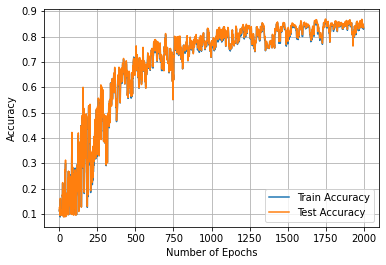

In [ ]:
train_accuracy = dnn3.train_accuracy_list
test_accuracy = dnn3.test_accuracy_list

plt.plot(train_accuracy,label='Train Accuracy')
plt.plot(test_accuracy,label='Test Accuracy')
plt.legend()
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.grid()
plt.savefig("accuracy_sgd.jpg")
plt.show()

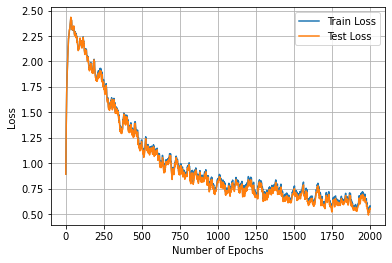

In [ ]:
train_loss = dnn3.train_loss_list
test_loss = dnn3.test_loss_list

plt.plot(train_loss,label='Train Loss')
plt.plot(test_loss,label='Test Loss')
plt.legend()
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.grid()
plt.savefig("loss_sgd.jpg")
plt.show()

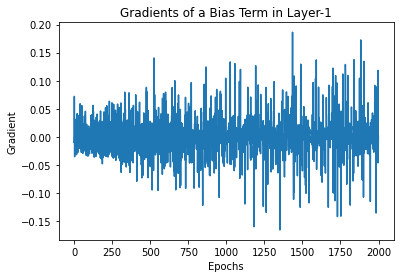

In [ ]:
grads = dnn3.grad_list

b1 = []
for i in range(len(grads)):
  b1.append(grads[i]["b1"][1,0])

plt.plot(b1)
plt.title("Gradients of a Bias Term in Layer-1")
plt.xlabel("Epochs")
plt.ylabel("Gradient")
plt.savefig("grad_sgd.jpg")
plt.show()

In [ ]:
# ReLU + SGD
dnn = DeepNeuralNetwork(sizes=[784, 64, 10], activation='sigmoid')
dnn.train(train_x, y_train1, test_x, y_test1,epochs=50, batch_size=128, optimizer='sgd', l_rate=0.05)

Epoch 1: 1.97257s, train acc=0.78527, train loss=1.10833, test acc=0.79560, test loss=1.08330
Epoch 2: 3.91371s, train acc=0.84982, train loss=0.75027, test acc=0.85910, test loss=0.72163
Epoch 3: 5.88638s, train acc=0.87410, train loss=0.60615, test acc=0.88010, test loss=0.57744
Epoch 4: 7.84074s, train acc=0.88675, train loss=0.52827, test acc=0.89260, test loss=0.50180
Epoch 5: 9.79119s, train acc=0.89327, train loss=0.48286, test acc=0.89920, test loss=0.45777
Epoch 6: 11.73238s, train acc=0.89930, train loss=0.44686, test acc=0.90550, test loss=0.42362
Epoch 7: 13.68098s, train acc=0.90193, train loss=0.43132, test acc=0.90840, test loss=0.40980
Epoch 8: 15.85477s, train acc=0.90630, train loss=0.40690, test acc=0.91170, test loss=0.38706
Epoch 9: 17.83362s, train acc=0.90890, train loss=0.39337, test acc=0.91380, test loss=0.37476
Epoch 10: 19.79661s, train acc=0.91188, train loss=0.37622, test acc=0.91680, test loss=0.35943
Epoch 11: 21.71763s, train acc=0.91442, train loss=0.3

In [ ]:
train_accuracy = dnn.train_accuracy_list
test_accuracy = dnn.test_accuracy_list

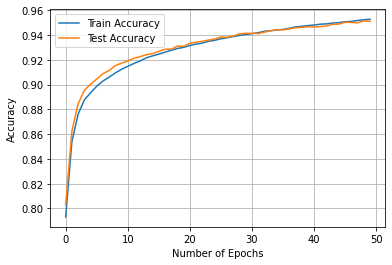

In [ ]:
plt.plot(train_accuracy,label='Train Accuracy')
plt.plot(test_accuracy,label='Test Accuracy')
plt.legend()
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.grid()
plt.savefig("accuracy.jpg")
plt.show()

In [ ]:
train_loss = dnn.train_loss_list
test_loss = dnn.test_loss_list

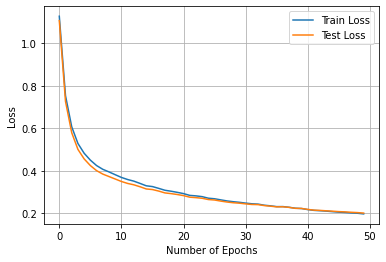

In [ ]:
plt.plot(train_loss,label='Train Loss')
plt.plot(test_loss,label='Test Loss')
plt.legend()
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.grid()
plt.savefig("loss.jpg")
plt.show()

In [ ]:
a = {1:10,2:5,3:6}
c = {1:10,2:5,3:6}
b = []
b.append(a)
b.append(c)
print(b[0])

{1: 10, 2: 5, 3: 6}


In [ ]:
grads = dnn.grad_list

In [ ]:
print(grads[0])

{'W2': array([[ 1.26212655e-02,  9.33035907e-03,  6.53833747e-03,
         1.83839719e-03,  1.72491460e-02,  7.23805533e-03,
         7.68300680e-03,  5.41502754e-03,  6.10696752e-03,
         8.62283366e-03,  3.02975030e-04,  9.47190591e-03,
         5.36394953e-03,  2.91628944e-03, -1.36694605e-03,
         4.37403983e-03,  4.06799047e-03,  6.28795976e-03,
         1.01525716e-02,  4.14067091e-03,  7.13297264e-03,
         1.55465374e-02,  3.39079812e-03,  1.16995945e-02,
         8.73078136e-03,  6.49157733e-03,  4.46097847e-03,
         5.85052061e-03,  4.92848519e-03,  4.04567455e-03,
         1.09223124e-02,  9.46203566e-03,  3.78342301e-03,
         1.24559042e-02,  9.72079355e-03,  2.81426845e-03,
         8.13962795e-03,  5.88316342e-03,  5.16943192e-03,
         2.69953431e-03,  1.41099808e-02,  5.15083307e-03,
         8.48886773e-03,  8.32810115e-03,  8.02060869e-03,
         6.20478478e-03,  8.77757354e-03,  1.37523212e-02,
         5.41249132e-03,  6.19122844e-03,  5.6993

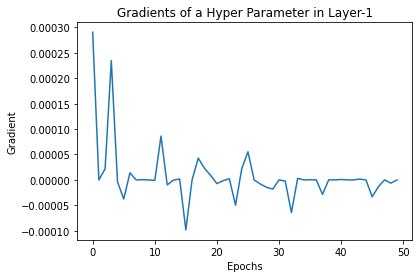

In [ ]:
w1 = []
w2 = []

for i in range(len(grads)):
  w1.append(grads[i]["W1"][0,68])

plt.plot(w1)
plt.title("Gradients of a Hyper Parameter in Layer-1")
plt.xlabel("Epochs")
plt.ylabel("Gradient")
plt.savefig("W1_68.jpg")
plt.show()

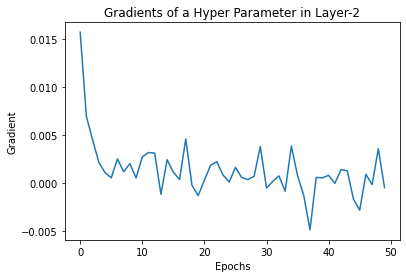

In [ ]:
w2 = []

for i in range(len(grads)):
  w2.append(grads[i]["W2"][0,59])

plt.plot(w2)
plt.title("Gradients of a Hyper Parameter in Layer-2")
plt.xlabel("Epochs")
plt.ylabel("Gradient")
plt.savefig("W2_59.jpg")
plt.show()

Index 0


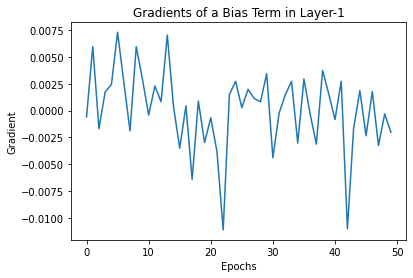

Index 1


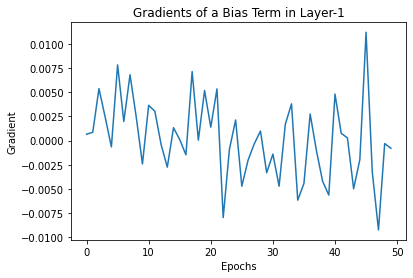

Index 2


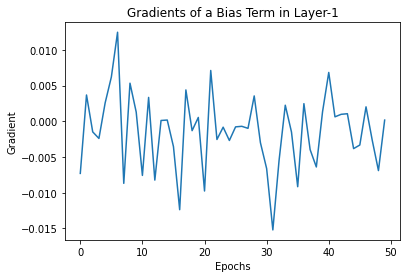

Index 3


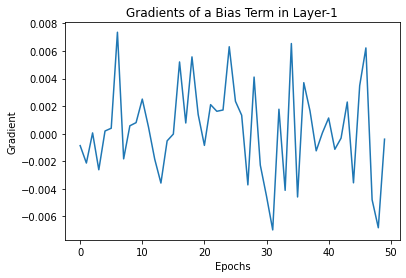

Index 4


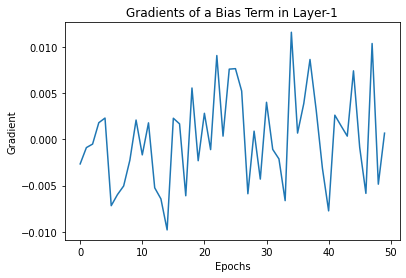

Index 5


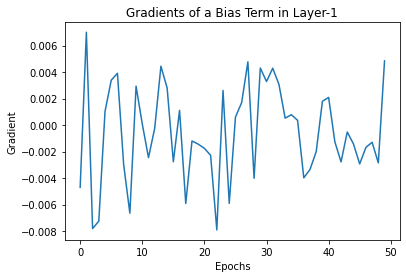

Index 6


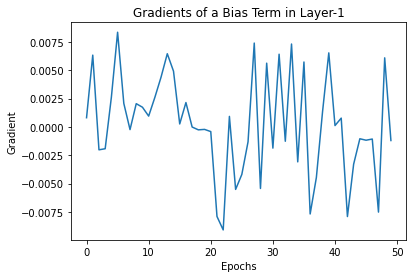

Index 7


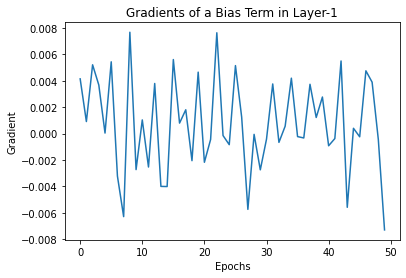

Index 8


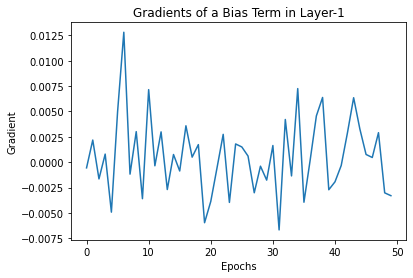

Index 9


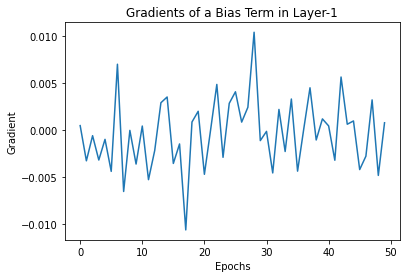

Index 10


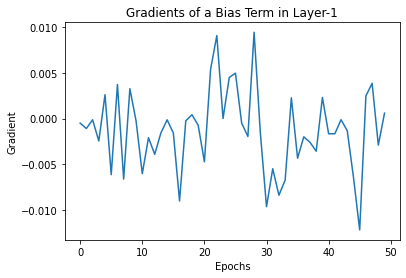

Index 11


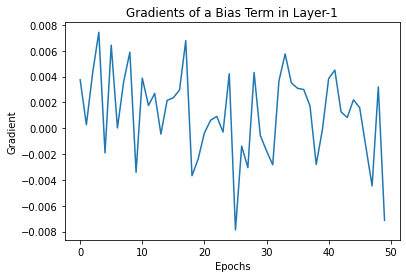

Index 12


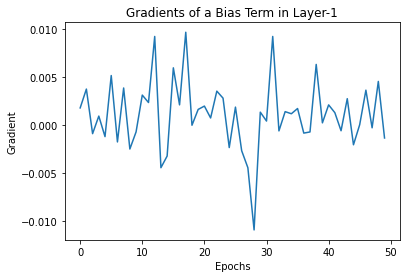

Index 13


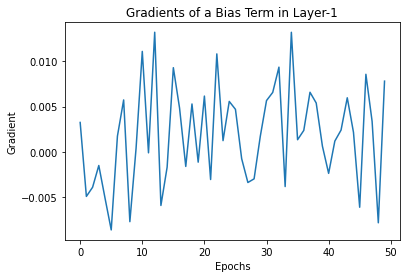

Index 14


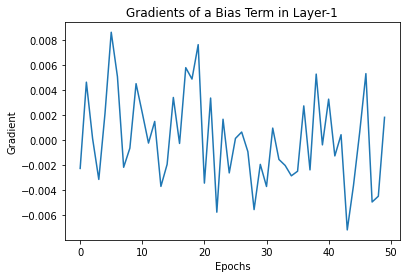

Index 15


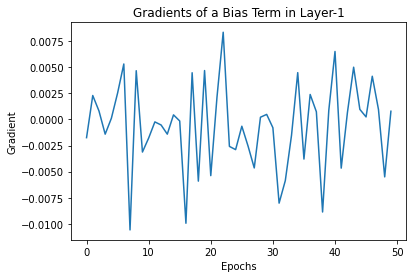

Index 16


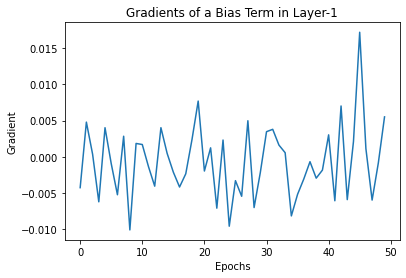

Index 17


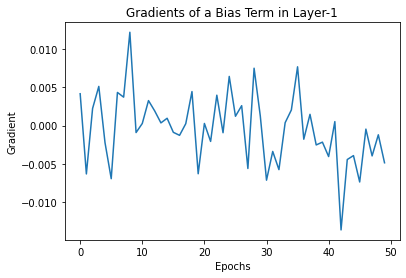

Index 18


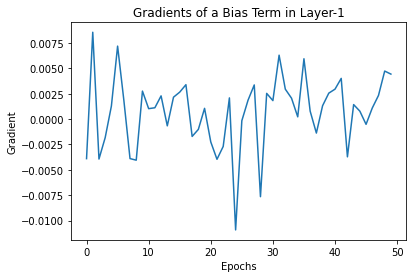

Index 19


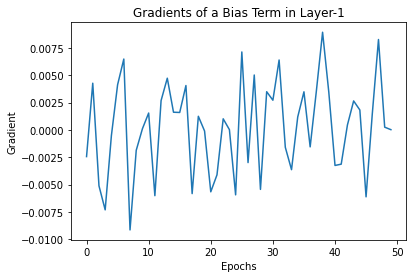

Index 20


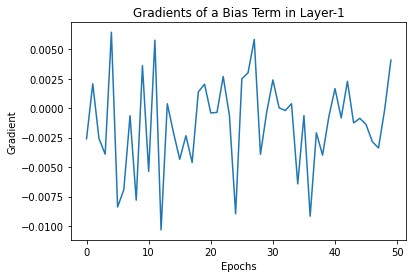

Index 21


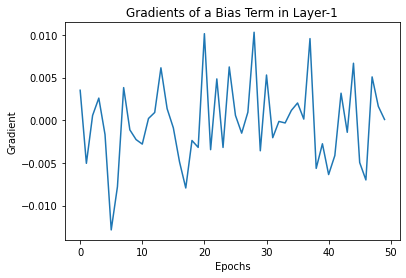

Index 22


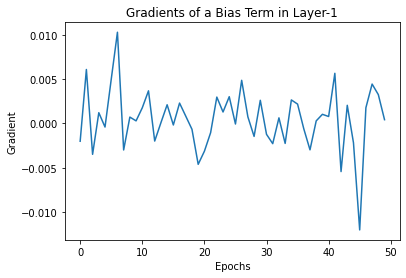

Index 23


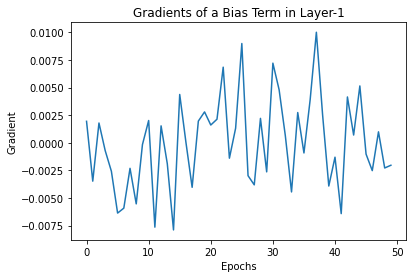

Index 24


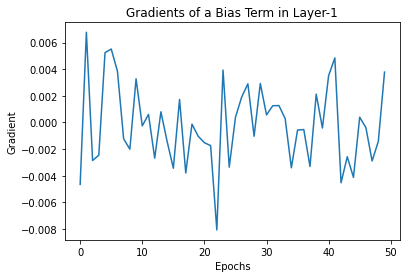

Index 25


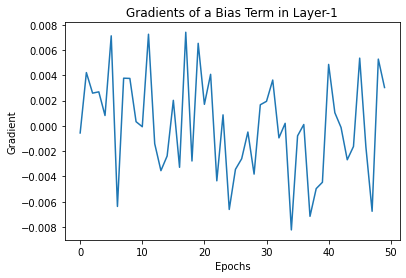

Index 26


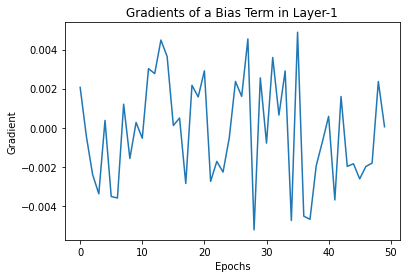

Index 27


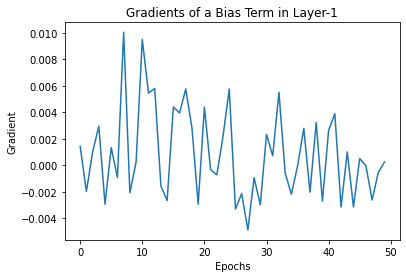

Index 28


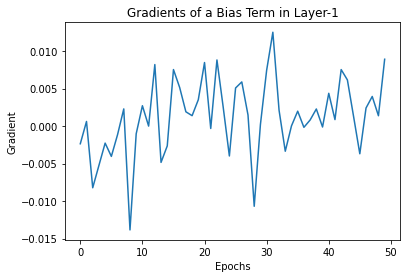

Index 29


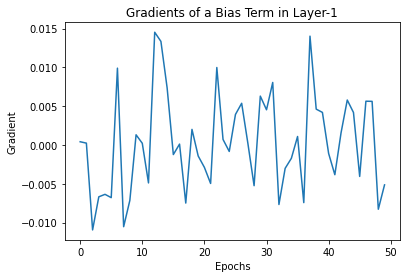

Index 30


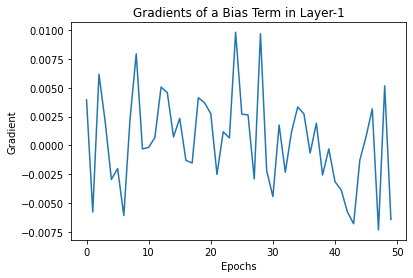

Index 31


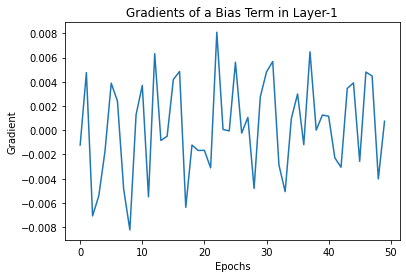

Index 32


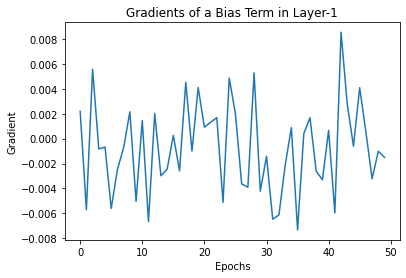

Index 33


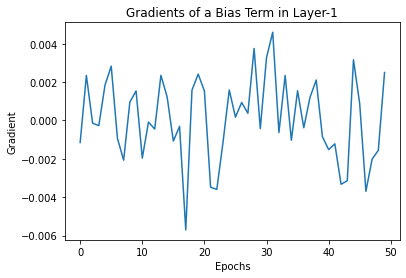

Index 34


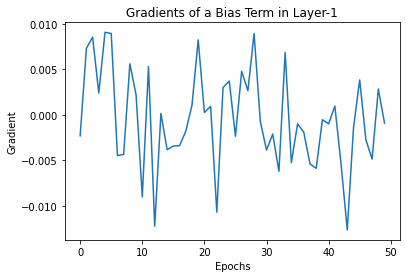

Index 35


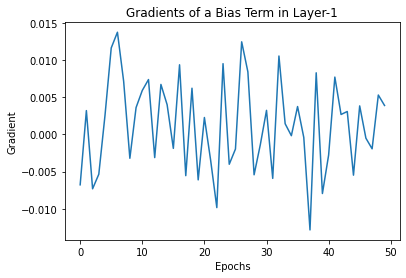

Index 36


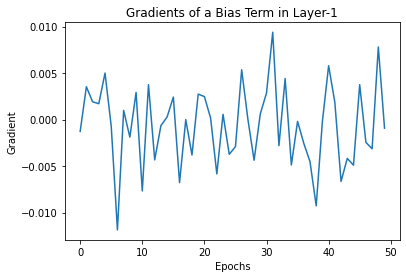

Index 37


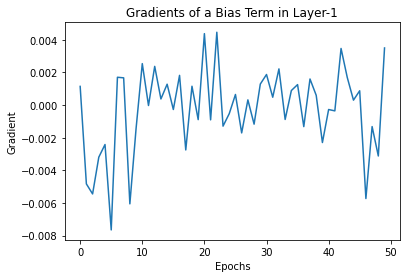

Index 38


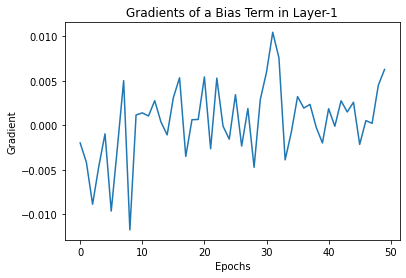

Index 39


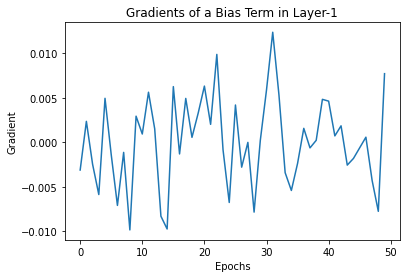

Index 40


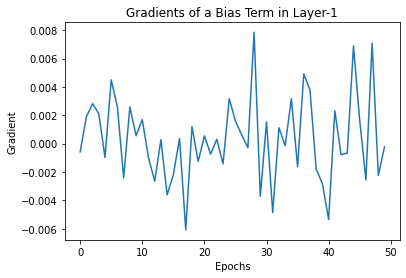

Index 41


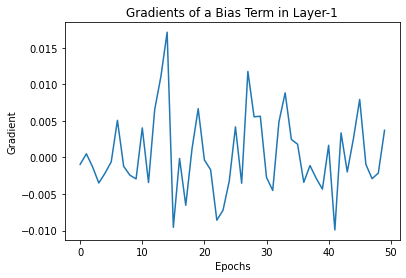

Index 42


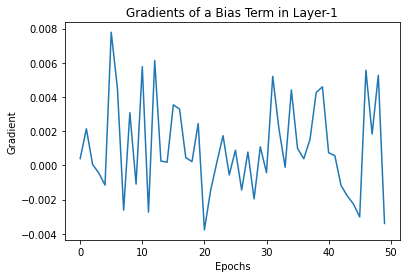

Index 43


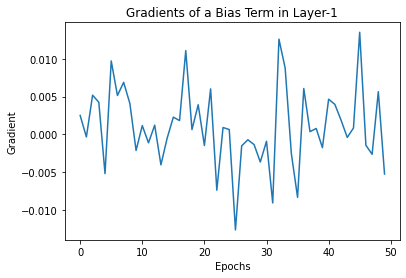

Index 44


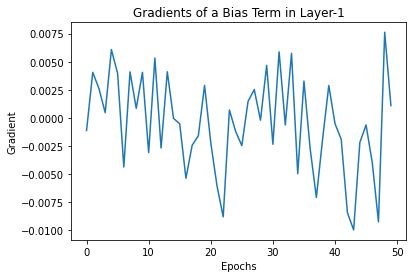

Index 45


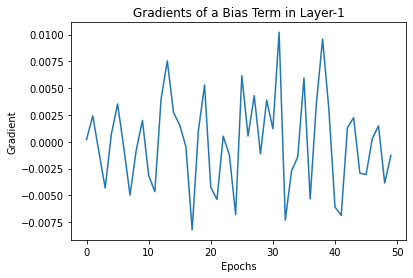

Index 46


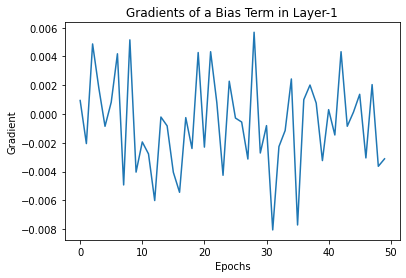

Index 47


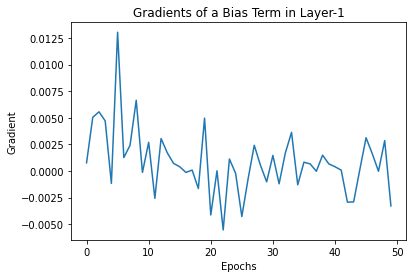

Index 48


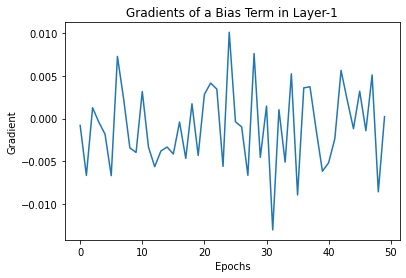

Index 49


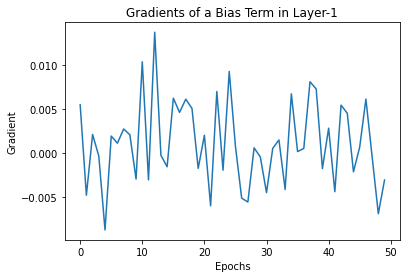

Index 50


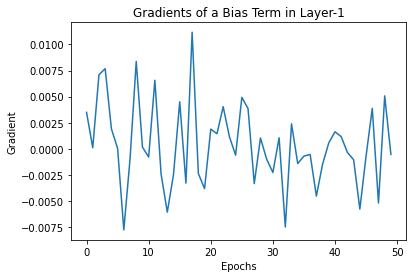

Index 51


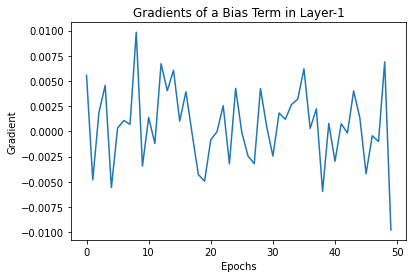

Index 52


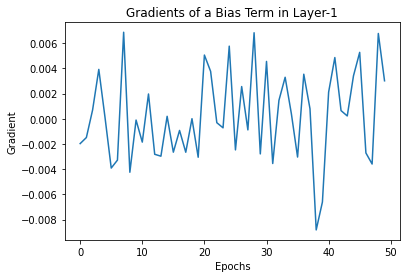

Index 53


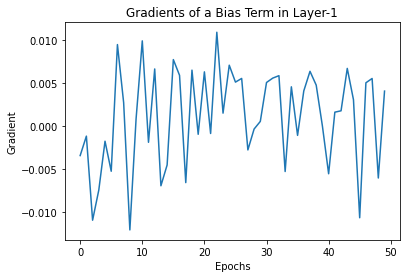

Index 54


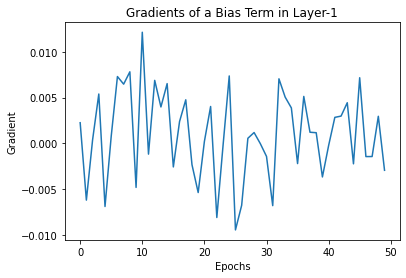

Index 55


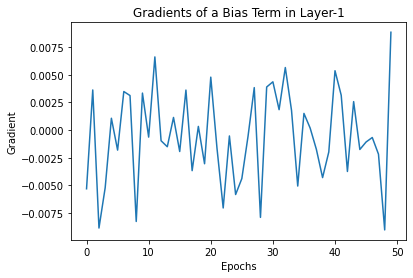

Index 56


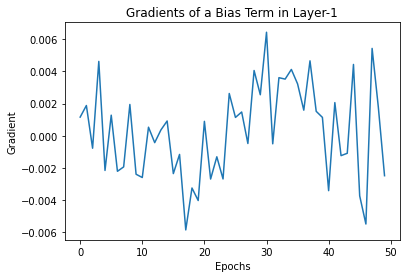

Index 57


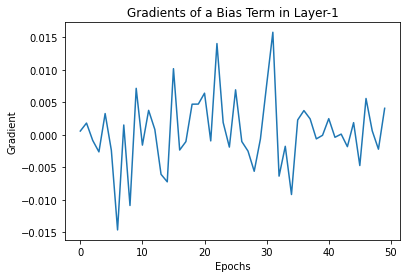

Index 58


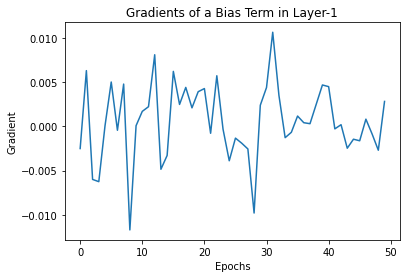

Index 59


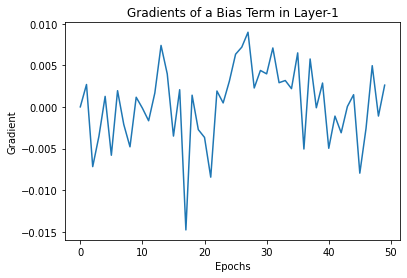

Index 60


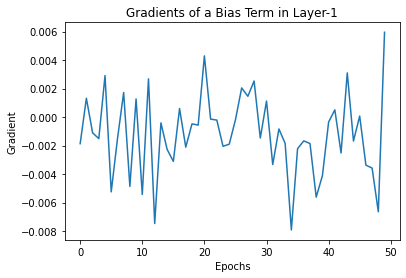

Index 61


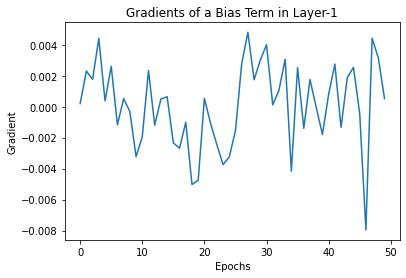

Index 62


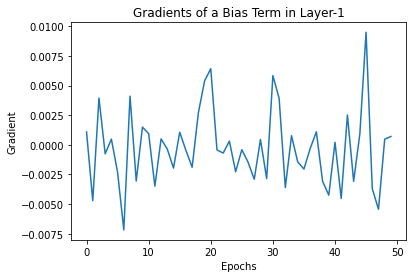

Index 63


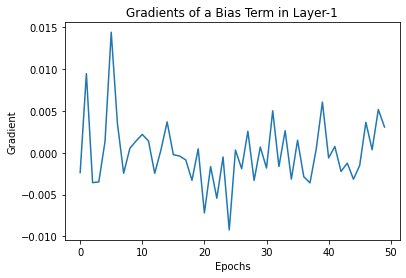

In [ ]:
for j in range(64):
  b1 = []
  print('Index',j)
  for i in range(len(grads)):
    b1.append(grads[i]["b1"][j,0])

  plt.plot(b1)
  plt.title("Gradients of a Bias Term in Layer-1")
  plt.xlabel("Epochs")
  plt.ylabel("Gradient")
  #plt.savefig("W2_68.jpg")
  plt.show()

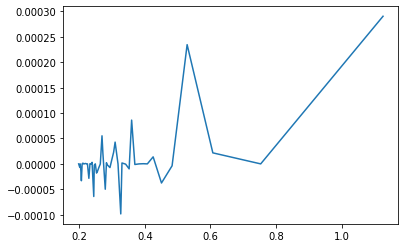

In [ ]:
plt.plot(train_loss,w1)

In [ ]:
from mpl_toolkits import mplot3d

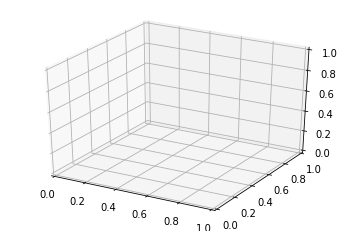

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')

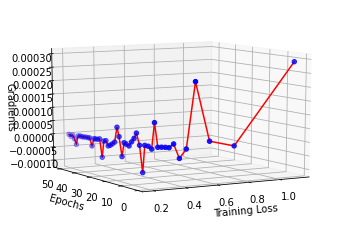

In [ ]:
ax = plt.axes(projection='3d')
ax.view_init(elev=10., azim=240)
# Data for a three-dimensional line
zline = w1
xline = np.linspace(1,51,50)
yline = train_loss
ax.set_xlabel("Training Loss")
ax.set_ylabel("Epochs")
ax.set_zlabel("Gradients")
ax.scatter3D(yline, xline, zline,c='blue')

ax.plot3D(yline, xline, zline,c='red')

plt.savefig("3DgradW1.jpg")
plt.show()



In [ ]:
"""X shape is (128, 784)
W1 shape is (64, 784)
Z1 shape is (64, 128)
A1 shape is (64, 128)
W2 shape is (10, 64)
A2 shape is (10,64)
y shape is (128,10)
"""